# Gesture Recognition
Build a 3D Conv model that will be able to predict the 5 gestures correctly.

In [43]:
#Connect to Google Drive - DNA added
#from google.colab import drive
#drive.mount('/content/gdrive/')

In [44]:
import numpy as np
import os
#from scipy.misc import imread, imresize
from imageio import imread
#from cv2 import resize
from skimage.transform import resize
import datetime
import os

import matplotlib.pyplot as plt
from PIL import Image

We set the random seed so that the results don't vary drastically.

In [45]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [46]:
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())

**Exploring the data**

In [47]:
import pandas as pd

df_data = pd.DataFrame()
#Creating empty list containers for video, action, and class
videos = []
actions = []
classes = []

#Traversing through the csv file and splitting video name into meaningful details and filling in lists
for video in train_doc:
  vidDetails = video.split(';')
  videos.append(vidDetails[0])
  actions.append(vidDetails[1])
  classes.append(vidDetails[2].strip())

#Populating the dataframe with names of videos, action happening in them, and the class
df_data['Video'] = videos
df_data['Action'] = actions
df_data['Class'] = classes

df_data.head()

,Video,Action,Class
0,WIN_20180926_16_54_08_Pro_Right_Swipe_new,Right_Swipe_new,1
1,WIN_20180925_18_02_58_Pro_Thumbs_Down_new,Thumbs_Down_new,3
2,WIN_20180925_17_33_08_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_17_51_17_Pro_Thumbs_Up_new,Thumbs_Up_new,4
4,WIN_20180926_17_17_35_Pro_Left_Swipe_new,Left_Swipe_new,0


<AxesSubplot:>

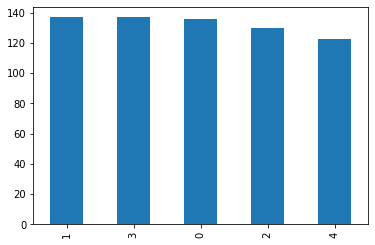

In [48]:
#Checking for data imbalance
df_data.Class.value_counts().plot(kind = 'bar')

We can see that there is no data imbalance. So there is no need of data augmentation

Picking one image from one of the videos, resizing, normalizing, and printing...

In [49]:
#Reading and checking shape of one random image from the data
testImg = imread('/datasets/Project_data/train/WIN_20180926_16_51_21_Pro_Thumbs_Down_new/WIN_20180926_16_51_21_Pro_00005.png')#.astype(np.float32)
testImg.shape

(120, 160, 3)

In [50]:
testImg[:2,:2,1]

Array([[126, 126],
       [127, 125]], dtype=uint8)

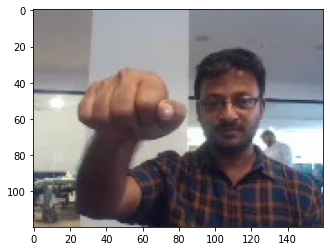

In [51]:
#Printing the image read above, as it is
plt.imshow(testImg)

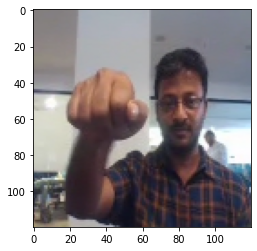

In [52]:
#Resizing the image and printing again
testImg = resize(testImg,(120,120))
plt.imshow(testImg)

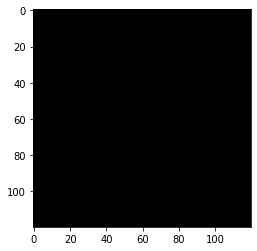

In [53]:
#Normalizing the image and printing again
testImgN = testImg/255
plt.imshow(testImgN)

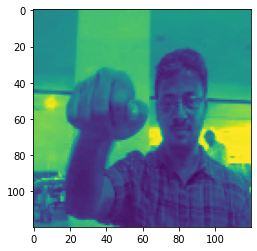

In [54]:
#Printing one channel of the resized and normalized image
plt.imshow(testImgN[:,:,2])

In [55]:
#Trying to find the mean of each of the 3 channels throughout the train data
import glob

red = 0
blue = 0
green = 0
totalImages = 0
for rootdir, dirs, files in os.walk('/datasets/Project_data/train'):
    for subdir in dirs:
        video_dir = os.path.join(rootdir, subdir)       
        for count, file in enumerate(glob.glob(video_dir + "/*.png")):
            image = imread(file).astype(np.float32)
            red = red + np.mean(np.reshape(image[:,:,0], -1))
            blue  = blue + np.mean(np.reshape(image[:,:,0], -1))
            green = green + np.mean(np.reshape(image[:,:,0], -1))
        totalImages = totalImages + count   
print('Total Images = ' + str(totalImages))
print(red/totalImages)
print(blue/totalImages)
print(green/totalImages)

Total Images = 19227
127.76309182971627
127.76309182971627
127.76309182971627


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [56]:
def generator(source_path, folder_list, batch_size, num_frames, img_height, img_width):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,29,num_frames)).astype(int)#create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y = img_height
    z = img_width
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        #print('DNA logs - Number of batches to produce = ' + str(num_batches))
        for batch in range(num_batches): # we iterate over the number of batches
            #print('DNA logs - batch being processed = ' + str(batch))
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                #print('    DNA logs - video being processed for current batch = ' + str(folder))
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #print('        DNA logs - Image being processed for current video = ' + str(idx))
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(y,z)).astype(np.float32)
                    else:
                        image = resize(image,(y,z)).astype(np.float32)    
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 127.76 # /255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 127.76 # /255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 127.76 # /255.0 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        # Reutilizing batch variable from above to keep a track of the last batch to be processed
        last_batch_size = len(t)%batch_size 
        #print('DNA logs - Last batch size = ' + str(last_batch_size))
        if last_batch_size > 0:     
          batch_data = np.zeros((last_batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
          batch_labels = np.zeros((last_batch_size,5)) # batch_labels is the one hot representation of the output
          for folder in range(last_batch_size): # iterate over the batch_size
              #print('DNA logs - Iterating for last batch on video number - ' + str(folder))
              imgs = os.listdir(source_path+'/'+ t[folder + (batch*last_batch_size)].split(';')[0]) # read all the images in the folder
              for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                  image = imread(source_path+'/'+ t[folder + (batch*last_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                  
                  #crop the images and resize them. Note that the images are of 2 different shape 
                  #and the conv3D will throw error if the inputs in a batch have different shapes
                  if image.shape[1] == 160:
                      image = resize(image[:,20:140,:],(y,z)).astype(np.float32)
                  else:
                      image = resize(image,(y,z)).astype(np.float32)

                  batch_data[folder,idx,:,:,0] = image[:,:,0] - 127.76 #/255.0 #normalise and feed in the image
                  batch_data[folder,idx,:,:,1] = image[:,:,1] - 127.76 #/255.0 #normalise and feed in the image
                  batch_data[folder,idx,:,:,2] = image[:,:,2] - 127.76 #/255.0 #normalise and feed in the image
                  
              batch_labels[folder, int(t[folder + (num_batches*last_batch_size)].strip().split(';')[2])] = 1
          yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

Plotting performance 

In [57]:
def plot_performance(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [58]:
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [59]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here

## **Building of CONV3D model starts here**

**Conv3D Model 1 - Sample Model | Finding highest batch size**

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
#batch_size = 40
#Did not break with batch size 40 on Google colab, try for 50
batch_size = 50
num_frames = 20 
img_height = 120 
img_width = 120
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

Building the structure of model

In [ ]:
model = Sequential()

model.add(Conv3D(16, 
                 kernel_size=(3,3,3), 
                 padding='same',
                 activation='relu', 
                 input_shape=(num_frames,img_height,img_width,3)))
model.add(BatchNormalization())

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same',activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.20))

model.add(Dense(5, activation='softmax'))

Choosing the optimizer and compiling the model

In [ ]:
optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_9 (Batch (None, 20, 120, 120, 16)  64        
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 20, 120, 120, 32)  13856     
_________________________________________________________________
batch_normalization_10 (Batc (None, 20, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 10, 60, 60, 32)    0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152000)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

Creating the callback list along with the mechanism to save model weights

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
#Running for just 2 epoch to check the sanity, and to see if the batch size is okay 
history = model.fit_generator(train_generator, 
                              steps_per_epoch=steps_per_epoch, 
                              #epochs=num_epochs,
                              epochs=2,
                              verbose=1, 
                              #callbacks=callbacks_list, 
                              validation_data=val_generator, 
                              validation_steps=validation_steps, 
                              class_weight=None, 
                              workers=1, 
                              initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  /content/gdrive/MyDrive/MachineLearning/GestureRecognition/Project_data/train ; batch size = 50
Epoch 1/2


ResourceExhaustedError: ignored

## <i> Did not break with Batch size 40. But broke with 50 on colab. We can continue with batch size 40 ahead on colab.

**Conv3D Model 2 - 1st model to run for full epochs**

In [ ]:
batch_size = 40
num_frames = 20 
img_height = 120 
img_width = 120
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

In [ ]:
#Building the structure of model
model = Sequential()

model.add(Conv3D(16, 
                 kernel_size=(3,3,3), 
                 padding='same',
                 activation='relu', 
                 input_shape=(num_frames,img_height,img_width,3)))
model.add(BatchNormalization())

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same',activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.20))

model.add(Dense(5, activation='softmax'))

In [ ]:
#Choosing the optimizer and compiling the model
optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_12 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 20, 120, 120, 32)  13856     
_________________________________________________________________
batch_normalization_13 (Batc (None, 20, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 10, 60, 60, 32)    0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1152000)           0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

In [ ]:
#Creating the callback list along with the mechanism to save model weights
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


In [ ]:
#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  /content/gdrive/MyDrive/MachineLearning/GestureRecognition/Project_data/train ; batch size = 40
Epoch 1/15
17/17 [==============================] - 66s 4s/step - loss: 1.7109 - categorical_accuracy: 0.4253 - val_loss: 2.1007 - val_categorical_accuracy: 0.3000

Epoch 00001: saving model to model_init_2021-08-2910_51_54.317655/model-00001-1.71094-0.42534-2.10066-0.30000.h5
Epoch 2/15
17/17 [==============================] - 65s 4s/step - loss: 1.1423 - categorical_accuracy: 0.5747 - val_loss: 38.0626 - val_categorical_accuracy: 0.2000

Epoch 00002: saving model to model_init_2021-08-2910_51_54.317655/model-00002-1.14227-0.57466-38.06258-0.20000.h5
Epoch 3/15
17/17 [==============================] - 64s 4s/step - loss: 0.8634 - categorical_accuracy: 0.6833 - val_loss: 76.4880 - val_categorical_accuracy: 0.2200

Epoch 00003: saving model to model_init_2021-08-2910_51_54.317655/model-00003-0.86336-0.68326-76.48800-0.22000.h5

Epoch 00003: ReduceLROnPlateau reducing learning r

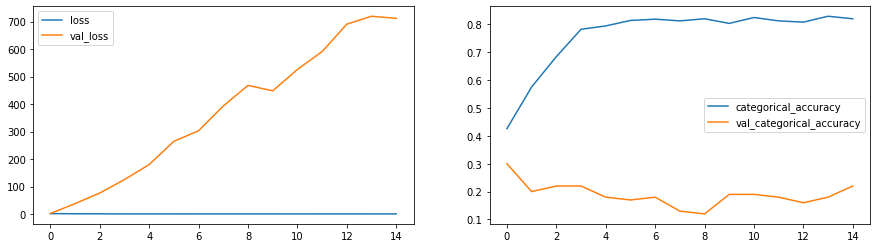

In [ ]:
#Let us now fit the model and plot accuracy and loss. 

history = model.fit_generator(train_generator, 
                              steps_per_epoch=steps_per_epoch, 
                              epochs=num_epochs,                              
                              verbose=1, 
                              callbacks=callbacks_list, 
                              validation_data=val_generator, 
                              validation_steps=validation_steps, 
                              class_weight=None, 
                              workers=1, 
                              initial_epoch=0)
plot_performance(history)

**Conv3D Model 3 - Changing the architecture and adding more layers. Previous one is not converging**

In [ ]:
# All hyperparameters are unchanged so we can reutilize the previous generator instance

#Building the structure of model
model = Sequential()

model.add(Conv3D(16, 
                 kernel_size=(3,3,3), 
                 padding='same',
                 activation='relu', 
                 input_shape=(num_frames,img_height,img_width,3)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.20))

model.add(Dense(5, activation='softmax'))

#Choosing the optimizer and compiling the model
optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_10 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_15 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_16 (Batc (None, 10, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 5, 30, 30, 32)     0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 5, 30, 30, 64)    

In [40]:
#Creating the callback list along with the mechanism to save model weights
model_name = 'Conv3D_Model_3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

We can resuse the previous steps_per_epoch and validation_steps as hyperparameters are unchanged

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
17/17 [==============================] - 67s 4s/step - loss: 1.2786 - categorical_accuracy: 0.5370 - val_loss: 1.6457 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to Conv3D_Model_3_2021-08-2910_51_54.317655/model-00001-1.27858-0.53695-1.64570-0.22000.h5
Epoch 2/15
17/17 [==============================] - 62s 4s/step - loss: 0.6763 - categorical_accuracy: 0.7496 - val_loss: 3.3921 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to Conv3D_Model_3_2021-08-2910_51_54.317655/model-00002-0.67633-0.74962-3.39207-0.23000.h5
Epoch 3/15
17/17 [==============================] - 61s 4s/step - loss: 0.3925 - categorical_accuracy: 0.8733 - val_loss: 4.9434 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to Conv3D_Model_3_2021-08-2910_51_54.317655/model-00003-0.39252-0.87330-4.94344-0.23000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/15
17/17 [==============================] - 61s 4s/step - loss: 

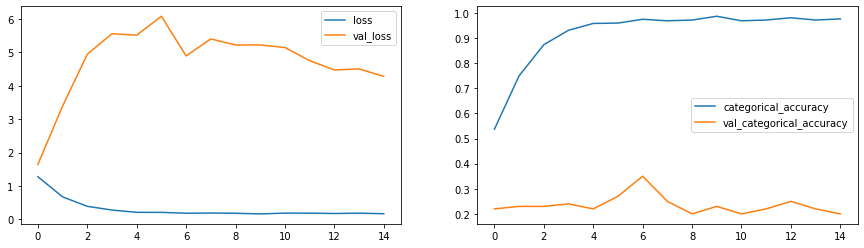

In [41]:
#Let us now fit the model and plot accuracy and loss. 

history = model.fit_generator(train_generator, 
                              steps_per_epoch=steps_per_epoch, 
                              epochs=num_epochs,                              
                              verbose=1, 
                              callbacks=callbacks_list, 
                              validation_data=val_generator, 
                              validation_steps=validation_steps, 
                              class_weight=None, 
                              workers=1, 
                              initial_epoch=0)
plot_performance(history)

Model is overfitting. 

Conv3D Model 4 - Previous model architecture but with smaller batch size

In [42]:
batch_size = 25
num_frames = 20 
img_height = 120 
img_width = 120
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

Source path =  /content/gdrive/MyDrive/MachineLearning/GestureRecognition/Project_data/train ; batch size = 25


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
27/27 [==============================] - 64s 2s/step - loss: 0.2054 - categorical_accuracy: 0.9578 - val_loss: 4.0272 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to Conv3D_Model_4_2021-08-2910_51_54.317655/model-00001-0.20536-0.95777-4.02716-0.22000.h5
Epoch 2/15
27/27 [==============================] - 62s 2s/step - loss: 0.2160 - categorical_accuracy: 0.9442 - val_loss: 3.9030 - val_categorical_accuracy: 0.2000

Epoch 00002: saving model to Conv3D_Model_4_2021-08-2910_51_54.317655/model-00002-0.21604-0.94419-3.90299-0.20000.h5
Epoch 3/15
27/27 [==============================] - 61s 2s/step - loss: 0.1938 - categorical_accuracy: 0.9653 - val_loss: 3.1284 - val_categorical_accuracy: 0.2500

Epoch 00003: saving model to Conv3D_Model_4_2021-08-2910_51_54.317655/model-00003-0.19378-0.96531-3.12842-0.25000.h5
Epoch 4/15
27/27 [==============================] - 61s 2s/step - loss: 0.1930 - categorical_accuracy: 0.9638 - val_loss: 3.0276 - val_categorical_accurac

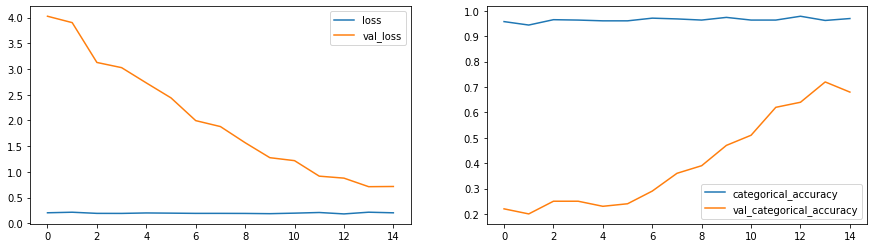

In [43]:
# We can reuse previous model, since we are changing only batch size

# Model is already compiled

#Creating the callback list along with the mechanism to save model weights
model_name = 'Conv3D_Model_4' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
#Let us now fit the model and plot accuracy and loss. 
history = model.fit_generator(train_generator, 
                              steps_per_epoch=steps_per_epoch, 
                              epochs=num_epochs,                              
                              verbose=1, 
                              callbacks=callbacks_list, 
                              validation_data=val_generator, 
                              validation_steps=validation_steps, 
                              class_weight=None, 
                              workers=1, 
                              initial_epoch=0)
plot_performance(history)

Batch size did not improve anything. The model is too complex for the data that we have. We need a simpler model that does not overfit

Conv3D_Model_5 - Create a new architecture and switch back to batch size of 40

In [45]:
batch_size = 40
num_frames = 20 
img_height = 120 
img_width = 120
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

In [46]:
#Building the structure of model
model = Sequential()

model.add(BatchNormalization(input_shape=(num_frames,img_height,img_width,3)))
model.add(Conv3D(16, 
                 kernel_size=(3,3,3), 
                 padding='same',
                 activation='relu', 
                 kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, 
                 kernel_size=(3,3,3), 
                 padding='same',
                 activation='relu', 
                 kernel_initializer='he_uniform',))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform',))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

#Choosing the optimizer and compiling the model
optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_19 (Batc (None, 20, 120, 120, 3)   12        
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 5, 30, 30, 32)     0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 144000)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

Source path =  /content/gdrive/MyDrive/MachineLearning/GestureRecognition/Project_data/train ; batch size = 40


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
17/17 [==============================] - 64s 4s/step - loss: 22.6797 - categorical_accuracy: 0.2594 - val_loss: 1.5956 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to Conv3D_Model_5_2021-08-2910_51_54.317655/model-00001-22.67973-0.25943-1.59564-0.24000.h5
Epoch 2/15
17/17 [==============================] - 69s 4s/step - loss: 1.5561 - categorical_accuracy: 0.3333 - val_loss: 1.6038 - val_categorical_accuracy: 0.3300

Epoch 00002: saving model to Conv3D_Model_5_2021-08-2910_51_54.317655/model-00002-1.55608-0.33333-1.60378-0.33000.h5
Epoch 3/15
17/17 [==============================] - 61s 4s/step - loss: 1.5535 - categorical_accuracy: 0.4268 - val_loss: 1.6042 - val_categorical_accuracy: 0.3000

Epoch 00003: saving model to Conv3D_Model_5_2021-08-2910_51_54.317655/model-00003-1.55347-0.42685-1.60424-0.30000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/15
17/17 [==============================] - 62s 4s/step - loss

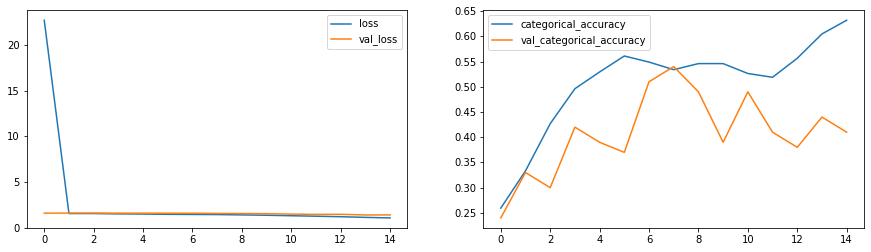

In [47]:
#Creating the callback list along with the mechanism to save model weights
model_name = 'Conv3D_Model_5' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

#Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
history = model.fit_generator(train_generator, 
                              steps_per_epoch=steps_per_epoch, 
                              epochs=num_epochs,
                              verbose=1, 
                              callbacks=callbacks_list, 
                              validation_data=val_generator, 
                              validation_steps=validation_steps, 
                              class_weight=None, 
                              workers=1, 
                              initial_epoch=0)
plot_performance(history)

Model needs improvement

**Conv3D_Model_6 - Making changes in the model architecture and keeping less layers. Using more samples, and reducing the image size further. We are trying to minimize the model parameters and the overall size because it is a business requirement that model should consume less memory**

In [60]:
batch_size = 40
num_frames = 20
img_height = 80
img_width = 80
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

In [61]:
#Building the structure of model
model = Sequential()

model.add(Conv3D(16, 
                 kernel_size=(2,2,2), 
                 padding='same',
                 activation='relu', 
                 kernel_initializer='he_uniform',
                 input_shape=(num_frames,img_height,img_width,3)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, 
                kernel_size=(3,3,3), 
                padding='same',
                activation='relu',
                kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.20))

model.add(Dense(5, activation='softmax'))


#Choosing the optimizer and compiling the model
optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 30, 100, 100, 16)  400       
_________________________________________________________________
batch_normalization_28 (Batc (None, 30, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 15, 50, 50, 32)    13856     
_________________________________________________________________
batch_normalization_29 (Batc (None, 15, 50, 50, 32)    128       
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 7, 25, 25, 32)     0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 140000)          

Source path =  /content/gdrive/MyDrive/MachineLearning/GestureRecognition/Project_data/train ; batch size = 40


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
17/17 [==============================] - 105s 6s/step - loss: 1.4943 - categorical_accuracy: 0.4902 - val_loss: 2.3026 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to Conv3D_Model_6_2021-08-2910_51_54.317655/model-00001-1.49433-0.49020-2.30256-0.29000.h5
Epoch 2/15
17/17 [==============================] - 105s 7s/step - loss: 0.8147 - categorical_accuracy: 0.7195 - val_loss: 1.6613 - val_categorical_accuracy: 0.3900

Epoch 00002: saving model to Conv3D_Model_6_2021-08-2910_51_54.317655/model-00002-0.81465-0.71946-1.66127-0.39000.h5
Epoch 3/15
17/17 [==============================] - 100s 6s/step - loss: 0.5189 - categorical_accuracy: 0.8250 - val_loss: 3.2438 - val_categorical_accuracy: 0.3100

Epoch 00003: saving model to Conv3D_Model_6_2021-08-2910_51_54.317655/model-00003-0.51885-0.82504-3.24378-0.31000.h5
Epoch 4/15
17/17 [==============================] - 103s 6s/step - loss: 0.3406 - categorical_accuracy: 0.9110 - val_loss: 5.2726 - val_categorical_acc

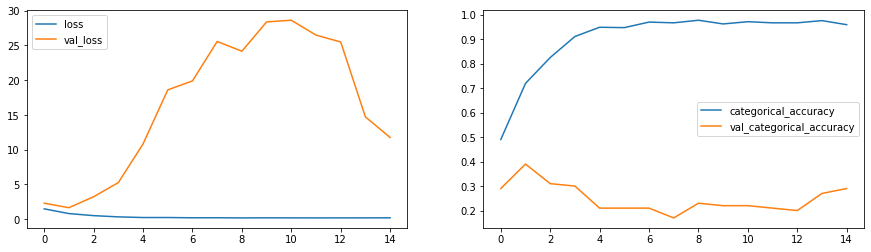

In [62]:
#Creating the callback list along with the mechanism to save model weights
model_name = 'Conv3D_Model_6' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

#Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, 
                              steps_per_epoch=steps_per_epoch, 
                              epochs=num_epochs,
                              verbose=1, 
                              callbacks=callbacks_list, 
                              validation_data=val_generator, 
                              validation_steps=validation_steps, 
                              class_weight=None, 
                              workers=1, 
                              initial_epoch=0)
plot_performance(history)

## Moved the notebook from colab to Jarvis from this point. Jarvis is allowing bigger batch size.
## Minor changes have been made in the generator code above. From here we will proceed with trying to converge more models, on Jarvis.

<b> Conv3D_Model_7 - Changing the architecture, taking a higher batch size, reducing number of frames and image size, and running for 20 epochs.
    Choosing elu instead of Relu to avoid Dying Relu problem if that is causing the model to fail completely and not learn

In [25]:
num_epochs = 20
batch_size = 40
num_frames = 18 
img_height = 84 
img_width = 84
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

In [26]:
#Building the structure of model
model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(num_frames,img_height,img_width,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))


#Choosing the optimizer and compiling the model
optimiser = optimizers.SGD(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 18, 84, 84, 64)    5248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 18, 84, 84, 64)    256       
_________________________________________________________________
activation_7 (Activation)    (None, 18, 84, 84, 64)    0         
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 9, 42, 84, 64)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 9, 42, 84, 128)    221312    
_________________________________________________________________
batch_normalization_8 (Batch (None, 9, 42, 84, 128)    512       
_________________________________________________________________
activation_8 (Activation)    (None, 9, 42, 84, 128)   

Source path =  /datasets/Project_data/train ; batch size = 40
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 6.3843 - categorical_accuracy: 0.3288Source path =  /datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 1.69984, saving model to Conv3D_Model_7_2021-08-3019_29_29.511897/model-00001-6.38433-0.32881-1.69984-0.16000.h5
17/17 [==============================] - 55s 3s/step - loss: 6.3843 - categorical_accuracy: 0.3288 - val_loss: 1.6998 - val_categorical_accuracy: 0.1600
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.2942 - categorical_accuracy: 0.4811
Epoch 00002: val_loss did not improve from 1.69984
17/17 [==============================] - 55s 3s/step - loss: 1.2942 - categorical_accuracy: 0.4811 - val_loss: 1.7384 - val_categorical_accuracy: 0.2200
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 1.1764 - categorical_accuracy: 0.5400
Epoch 00003: val_loss did not improve from 1.69

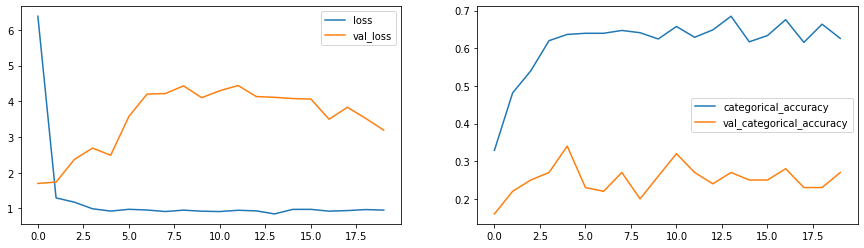

In [27]:

#Creating the callback list along with the mechanism to save model weights
model_name = 'Conv3D_Model_7' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

#Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, 
                              steps_per_epoch=steps_per_epoch, 
                              epochs=num_epochs,
                              verbose=1, 
                              callbacks=callbacks_list, 
                              validation_data=val_generator, 
                              validation_steps=validation_steps, 
                              class_weight=None, 
                              workers=1, 
                              initial_epoch=0)
plot_performance(history)


The model is still highly overfitting. Nothing seems to be working. Trying to make the model simple now..

<b> Conv3D_Model_8 - Making the architecture simpler. Keeping the hyperparameters same

In [26]:
num_epochs = 20
batch_size = 60
num_frames = 18 
img_height = 84 
img_width = 84
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

In [27]:
#Building the structure of model
model = Sequential()
model.add(Conv3D(16, (3,3,3), strides=(1,1,1), padding='same', input_shape=(num_frames,img_height,img_width,3)))
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

#model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(128, activation='elu'))
#model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))


#Choosing the optimizer and compiling the model
optimiser = optimizers.SGD(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 18, 84, 84, 16)    1312      
_________________________________________________________________
activation_8 (Activation)    (None, 18, 84, 84, 16)    0         
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 9, 42, 84, 16)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 9, 42, 84, 32)     13856     
_________________________________________________________________
activation_9 (Activation)    (None, 9, 42, 84, 32)     0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 9, 42, 84, 32)     128       
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 4, 21, 42, 32)    

Source path =  /datasets/Project_data/train ; batch size = 60
Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 2.9254 - categorical_accuracy: 0.2700Source path =  /datasets/Project_data/val ; batch size = 60

Epoch 00001: val_loss improved from inf to 1.60002, saving model to Conv3D_Model_8_2021-08-3021_48_11.006974/model-00001-2.92543-0.26998-1.60002-0.31000.h5
12/12 [==============================] - 54s 4s/step - loss: 2.9254 - categorical_accuracy: 0.2700 - val_loss: 1.6000 - val_categorical_accuracy: 0.3100
Epoch 2/20
11/12 [==========================>...] - ETA: 3s - loss: 1.6349 - categorical_accuracy: 0.4000
Epoch 00002: val_loss did not improve from 1.60002
12/12 [==============================] - 50s 4s/step - loss: 1.6346 - categorical_accuracy: 0.3997 - val_loss: 1.8531 - val_categorical_accuracy: 0.2600
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 1.3766 - categorical_accuracy: 0.4706
Epoch 00003: val_loss did not improve from 1.60

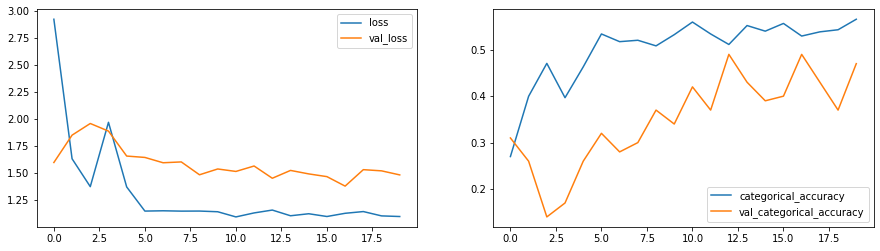

In [28]:
#Creating the callback list along with the mechanism to save model weights
model_name = 'Conv3D_Model_8' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

#Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, 
                              steps_per_epoch=steps_per_epoch, 
                              epochs=num_epochs,
                              verbose=1, 
                              callbacks=callbacks_list, 
                              validation_data=val_generator, 
                              validation_steps=validation_steps, 
                              class_weight=None, 
                              workers=1, 
                              initial_epoch=0)
plot_performance(history)


Nothing seems to have worked. We have tried changing the architecture, the activation function, optimizer, batches, epochs, image size. 

This leaves us with only one possible problem - a problem with the data that the network is receiving to train on. 

We will go back and change the normalization technique in the generator from simply dividing by 255 to per-channel mean-normalized by the values 104, 117, 123

<b>Conv3D_Model_9 - Trying to build another model, this time the normalization technique has been changed in the generator. We are also trying to keep the parameters minimum so that the model is light because that is a business requirement

In [27]:
num_epochs = 20
batch_size = 20
num_frames = 18 
img_height = 84 
img_width = 84
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

In [28]:
#Building the structure of model
model = Sequential()
model.add(Conv3D(16, (3,3,3), strides=(1,1,1), padding='same', input_shape=(num_frames,img_height,img_width,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))


#Choosing the optimizer and compiling the model
optimiser = optimizers.SGD(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 18, 84, 84, 16)    1312      
_________________________________________________________________
batch_normalization_3 (Batch (None, 18, 84, 84, 16)    64        
_________________________________________________________________
activation_3 (Activation)    (None, 18, 84, 84, 16)    0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 9, 42, 84, 16)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 9, 42, 84, 32)     13856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 9, 42, 84, 32)     128       
_________________________________________________________________
activation_4 (Activation)    (None, 9, 42, 84, 32)    

In [29]:
#Creating the callback list along with the mechanism to save model weights
model_name = 'Conv3D_Model_9' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', 
                       factor=0.2, 
                       patience=2, 
                       cooldown=1, 
                       verbose=1,
                       mode='min',
                       min_lr=0.00001) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

#Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, 
                              steps_per_epoch=steps_per_epoch, 
                              epochs=num_epochs,
                              verbose=1, 
                              callbacks=callbacks_list, 
                              validation_data=val_generator, 
                              validation_steps=validation_steps, 
                              class_weight=None, 
                              workers=1, 
                              initial_epoch=0)



Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 2.3911 - categorical_accuracy: 0.3333Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 3.53571, saving model to Conv3D_Model_9_2021-09-0114_21_44.882537/model-00001-2.39114-0.33333-3.53571-0.23000.h5
34/34 [==============================] - 83s 2s/step - loss: 2.3911 - categorical_accuracy: 0.3333 - val_loss: 3.5357 - val_categorical_accuracy: 0.2300
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1628 - categorical_accuracy: 0.5370
Epoch 00002: val_loss improved from 3.53571 to 2.44210, saving model to Conv3D_Model_9_2021-09-0114_21_44.882537/model-00002-1.16278-0.53695-2.44210-0.26000.h5
34/34 [==============================] - 85s 2s/step - loss: 1.1628 - categorical_accuracy: 0.5370 - val_loss: 2.4421 - val_categorical_accuracy: 0.2600
Epoch 3/20
34/34 [==========================

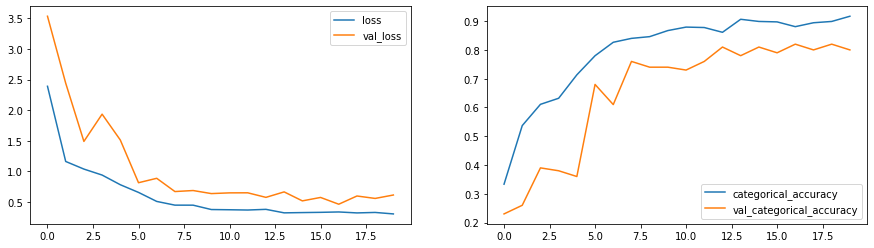

In [30]:
plot_performance(history)

This is a better model. Learning is happening and we can see the loss gradually decreasing. THis means that changing the image normalization strategy has solved our problem. We can see that at around epoch 13, further loss has stopped and we can utilize the weights of epoch 13. We can see that the metrics for epoch 13 are: categorical_accuracy: 0.8612 
val_categorical_accuracy: 0.8100 

This is not great but keeping in mind that we also need the model to be light, this is a good compromise.

If we make the model more complex, it can be more accurate but it will also consume more memory. We can try a few more variations ahead.

<b> Conv3D_Model_10 - Trying to reduce the parameters further, while making the model deeper

In [31]:
num_epochs = 25
batch_size = 20
num_frames = 18 
img_height = 84 
img_width = 84
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

In [32]:
#Building the structure of model
model = Sequential()
model.add(Conv3D(8, (3,3,3), strides=(1,1,1), padding='same', input_shape=(num_frames,img_height,img_width,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(16, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (2,2,2), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (2,2,2), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))


#Choosing the optimizer and compiling the model
optimiser = optimizers.SGD(lr=0.002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 18, 84, 84, 8)     656       
_________________________________________________________________
batch_normalization_6 (Batch (None, 18, 84, 84, 8)     32        
_________________________________________________________________
activation_6 (Activation)    (None, 18, 84, 84, 8)     0         
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 9, 42, 84, 8)      0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 9, 42, 84, 16)     3472      
_________________________________________________________________
batch_normalization_7 (Batch (None, 9, 42, 84, 16)     64        
_________________________________________________________________
activation_7 (Activation)    (None, 9, 42, 84, 16)    

In [33]:
#Creating the callback list along with the mechanism to save model weights
model_name = 'Conv3D_Model_10' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', 
                       factor=0.2, 
                       patience=2, 
                       cooldown=1, 
                       verbose=1,
                       mode='min',
                       min_lr=0.00001) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

#Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, 
                              steps_per_epoch=steps_per_epoch, 
                              epochs=num_epochs,
                              verbose=1, 
                              callbacks=callbacks_list, 
                              validation_data=val_generator, 
                              validation_steps=validation_steps, 
                              class_weight=None, 
                              workers=1, 
                              initial_epoch=0)



Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8199 - categorical_accuracy: 0.3318Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 2.19732, saving model to Conv3D_Model_10_2021-09-0114_21_44.882537/model-00001-1.81989-0.33183-2.19732-0.23000.h5
34/34 [==============================] - 84s 2s/step - loss: 1.8199 - categorical_accuracy: 0.3318 - val_loss: 2.1973 - val_categorical_accuracy: 0.2300
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3481 - categorical_accuracy: 0.4600
Epoch 00002: val_loss did not improve from 2.19732
34/34 [==============================] - 86s 3s/step - loss: 1.3481 - categorical_accuracy: 0.4600 - val_loss: 2.3923 - val_categorical_accuracy: 0.2600
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1981 - categorical_accuracy: 0.5264
Epoch 00003: val_loss improved from 2.19732 to

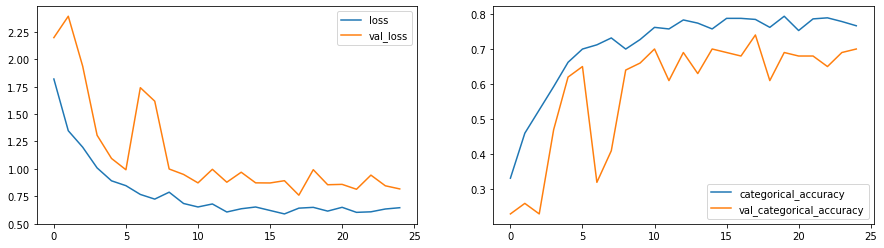

In [34]:
plot_performance(history)

We can see that after the 18th epoch, we have got the best results. Training categorical_accuracy: 78% , and validation categorical_accuracy: 74%.

<b>This model also has least number of parameters so it is lightweight and occupies less memory. It's performance is not excellent but it should be considered if we want a small and lightweight model

## **Building of CNN+RNN model starts here**

<b> CNN_RNN_Model1 - This is a CNN + RNN(GRU) model

In [35]:
num_epochs = 20
batch_size = 20
num_frames = 18 
img_height = 84 
img_width = 84
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

In [36]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [37]:
#Building the structure of model

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(num_frames,img_height,img_width,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(GRU(128))
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))


#Choosing the optimizer and compiling the model
optimiser = optimizers.SGD(lr=0.002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 84, 84, 16)    448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 84, 84, 16)    64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 42, 42, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 42, 42, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 42, 42, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 21, 21, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 21, 21, 64)   

In [38]:
#Creating the callback list along with the mechanism to save model weights
model_name = 'CNN_RNN_Model1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', 
                       factor=0.2, 
                       patience=2, 
                       cooldown=1, 
                       verbose=1,
                       mode='min',
                       min_lr=0.00001) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

#Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, 
                              steps_per_epoch=steps_per_epoch, 
                              epochs=num_epochs,
                              verbose=1, 
                              callbacks=callbacks_list, 
                              validation_data=val_generator, 
                              validation_steps=validation_steps, 
                              class_weight=None, 
                              workers=1, 
                              initial_epoch=0)


Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6583 - categorical_accuracy: 0.2775Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.81411, saving model to CNN_RNN_Model1_2021-09-0114_21_44.882537/model-00001-1.65830-0.27753-1.81411-0.32000.h5
34/34 [==============================] - 83s 2s/step - loss: 1.6583 - categorical_accuracy: 0.2775 - val_loss: 1.8141 - val_categorical_accuracy: 0.3200
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.3313 - categorical_accuracy: 0.4630
Epoch 00002: val_loss did not improve from 1.81411
34/34 [==============================] - 83s 2s/step - loss: 1.3313 - categorical_accuracy: 0.4630 - val_loss: 1.8662 - val_categorical_accuracy: 0.2700
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1357 - categorical_accuracy: 0.5611
Epoch 00003: val_loss improved from 1.81411 to 

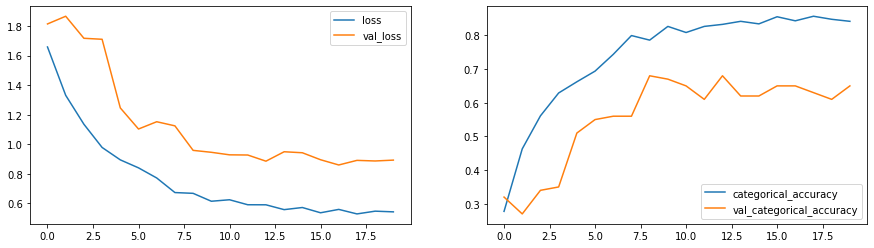

In [39]:
plot_performance(history)

We can pick the results from epoch 17.

Training categorical_accuracy: 84%
Valuation categorical_accuracy: 65%

The accuracy is not great. But the model has learnt. Loss reduction has been constant for both train and validation.

Number of parameters is high, so the model size will be big and is thus not suitable for our given business scenario

<b> CNN_RNN_Model2 - Trying to reduce the parameters to reduce the model size

In [60]:
num_epochs = 20
batch_size = 20
num_frames = 18 
img_height = 84 
img_width = 84
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

In [61]:
#Building the structure of model

model = Sequential()

model.add(TimeDistributed(Conv2D(8, (3, 3) , padding='same', activation='relu'),input_shape=(num_frames,img_height,img_width,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (2, 2) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64))
model.add(Dropout(0.2))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))


#Choosing the optimizer and compiling the model
optimiser = optimizers.SGD(lr=0.002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_23 (TimeDis (None, 18, 84, 84, 8)     224       
_________________________________________________________________
time_distributed_24 (TimeDis (None, 18, 84, 84, 8)     32        
_________________________________________________________________
time_distributed_25 (TimeDis (None, 18, 42, 42, 8)     0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, 18, 42, 42, 16)    1168      
_________________________________________________________________
time_distributed_27 (TimeDis (None, 18, 42, 42, 16)    64        
_________________________________________________________________
time_distributed_28 (TimeDis (None, 18, 21, 21, 16)    0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, 18, 21, 21, 32)   

In [62]:
#Creating the callback list along with the mechanism to save model weights
model_name = 'CNN_RNN_Model2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', 
                       factor=0.2, 
                       patience=2, 
                       cooldown=1, 
                       verbose=1,
                       mode='min',
                       min_lr=0.00001) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

#Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, 
                              steps_per_epoch=steps_per_epoch, 
                              epochs=num_epochs,
                              verbose=1, 
                              callbacks=callbacks_list, 
                              validation_data=val_generator, 
                              validation_steps=validation_steps, 
                              class_weight=None, 
                              workers=1, 
                              initial_epoch=0)


Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.8158 - categorical_accuracy: 0.2127Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.59129, saving model to CNN_RNN_Model2_2021-09-0116_22_17.202701/model-00001-1.81584-0.21267-1.59129-0.23000.h5
34/34 [==============================] - 85s 3s/step - loss: 1.8158 - categorical_accuracy: 0.2127 - val_loss: 1.5913 - val_categorical_accuracy: 0.2300
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.5968 - categorical_accuracy: 0.2911
Epoch 00002: val_loss improved from 1.59129 to 1.51463, saving model to CNN_RNN_Model2_2021-09-0116_22_17.202701/model-00002-1.59677-0.29110-1.51463-0.30000.h5
34/34 [==============================] - 83s 2s/step - loss: 1.5968 - categorical_accuracy: 0.2911 - val_loss: 1.5146 - val_categorical_accuracy: 0.3000
Epoch 3/20
34/34 [==========================

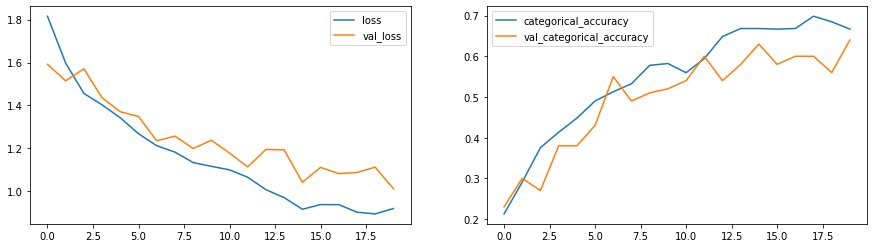

In [63]:
plot_performance(history)

This one is a considerably lighter model with less parameters.The performance is not too great but this is a better model than the previous one. 

After epoch 20 we can see:

Training categorical_accuracy: 66% 
Valuation categorical_accuracy: 64%

<b> CNN_RNN_TL_Model3 - CNN + RNN with Transfer learning 

In [64]:
num_epochs = 20
batch_size = 20
num_frames = 18 
img_height = 84 
img_width = 84
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

In [65]:
#Building the structure of model
from tensorflow.keras.applications import mobilenet
mobilenet_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

mobilenet_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 

In [66]:
#Set pre-trained model layers to not trainable
for layer in mobilenet_model.layers:
    layer.trainable = False

In [67]:
print(len(mobilenet_model.layers))

87


In [68]:
for layer in model.layers[55:]:
    layer.trainable =  True  

In [69]:


model = Sequential()

model.add(TimeDistributed(mobilenet_model,input_shape=(num_frames,img_height,img_width,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(GRU(64))
model.add(Dropout(0.2))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))


#Choosing the optimizer and compiling the model
optimiser = optimizers.SGD(lr=0.002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_36 (TimeDis (None, 18, 2, 2, 1024)    3228864   
_________________________________________________________________
time_distributed_37 (TimeDis (None, 18, 2, 2, 1024)    4096      
_________________________________________________________________
time_distributed_38 (TimeDis (None, 18, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, 18, 1024)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)               

In [70]:
#Creating the callback list along with the mechanism to save model weights
model_name = 'CNN_RNN_TL_Model3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', 
                       factor=0.2, 
                       patience=2, 
                       cooldown=1, 
                       verbose=1,
                       mode='min',
                       min_lr=0.00001) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

#Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, 
                              steps_per_epoch=steps_per_epoch, 
                              epochs=num_epochs,
                              verbose=1, 
                              callbacks=callbacks_list, 
                              validation_data=val_generator, 
                              validation_steps=validation_steps, 
                              class_weight=None, 
                              workers=1, 
                              initial_epoch=0)


Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.8406 - categorical_accuracy: 0.1810Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.71861, saving model to CNN_RNN_TL_Model3_2021-09-0116_22_17.202701/model-00001-1.84056-0.18100-1.71861-0.16000.h5
34/34 [==============================] - 84s 2s/step - loss: 1.8406 - categorical_accuracy: 0.1810 - val_loss: 1.7186 - val_categorical_accuracy: 0.1600
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.7529 - categorical_accuracy: 0.1810
Epoch 00002: val_loss improved from 1.71861 to 1.66625, saving model to CNN_RNN_TL_Model3_2021-09-0116_22_17.202701/model-00002-1.75288-0.18100-1.66625-0.16000.h5
34/34 [==============================] - 83s 2s/step - loss: 1.7529 - categorical_accuracy: 0.1810 - val_loss: 1.6663 - val_categorical_accuracy: 0.1600
Epoch 3/20
34/34 [====================

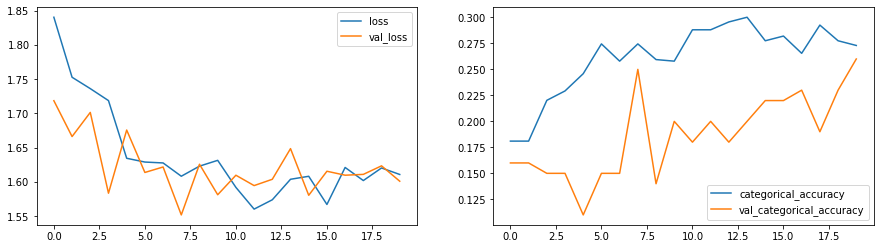

In [71]:
plot_performance(history)

The above model was an attempt to use Transfer learning where we utilized MobileNet model, made all its layers starting from 55 as trainable, and froze the rest.

This model has not learned well, and it must not be used.